# Generate music with an RNN

This Jupyter notebook presents a comprehensive study on the application of Recurrent Neural Networks (RNNs) for the task of music generation. The document encapsulates the methodology employed in constructing a neural network architecture that is capable of producing musical compositions. Utilizing TensorFlow's computational framework, the work systematically explores the intricacies of sequence modeling and pattern recognition inherent in music synthesis. The procedural narrative includes the formulation of the problem, data preprocessing techniques, model training procedures, and the evaluation of generated musical outputs. This scholarly endeavor aims to contribute to the field of computational creativity by demonstrating the potential of machine learning algorithms in artistic domains such as music

## Setup

In [1]:
!pip install pretty_midi
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Import the dataset

In [3]:
data_dir = pathlib.Path('/content/chopin')

import glob



midi_files = glob.glob(str(data_dir/'*.mid*'))
count = len(midi_files)
print(f"The total number of files found is: {count}")

The total number of files found is: 48


## Converting the notes to a DataFrame

In the development of the model, three variables are integral for the representation of a musical note: `pitch`, `step`, and `duration`. The `pitch` corresponds to the MIDI note number, reflecting the perceptual quality of the sound. `Step` is defined as the time interval elapsed since the commencement of the track or the previous note. Lastly, `duration` represents the temporal extent for which the note persists, calculated as the difference between the termination and initiation times of the note.

In [4]:
import pretty_midi
import pandas as pd
from collections import defaultdict
import numpy as np

def convert_midi_to_dataframe(midi_path: str) -> pd.DataFrame:
    # Load MIDI file
    pretty_midi_file = pretty_midi.PrettyMIDI(midi_path)
    primary_instrument = pretty_midi_file.instruments[0]

    # Extracting note information
    note_data = defaultdict(list)
    for note in sorted(primary_instrument.notes, key=lambda x: x.start):
        note_data['pitch'].append(note.pitch)
        note_data['start_time'].append(note.start)
        note_data['end_time'].append(note.end)
        note_data['duration'].append(note.end - note.start)

    # Creating pandas DataFrame from note data
    df = pd.DataFrame(note_data)
    df['time_step'] = df['start_time'].diff().fillna(0)
    return df


In [5]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start_time'], notes['end_time']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

Plot the notes for the entire track.

In [6]:
sample_file = midi_files[2]
print(sample_file)

raw_notes = convert_midi_to_dataframe(sample_file)
raw_notes.head(100)

/content/chopin/chpn-p8.mid


,pitch,start_time,end_time,duration,time_step
0,73,0.083333,0.166360,0.083026,0.000000
1,68,0.166360,0.248929,0.082569,0.083026
2,71,0.248929,0.331197,0.082267,0.082569
3,69,0.331197,0.413015,0.081819,0.082267
4,66,0.413015,0.494537,0.081522,0.081819
...,...,...,...,...,...
95,73,10.140684,10.245643,0.104959,0.207641
96,73,10.319534,10.393064,0.073529,0.178851
97,68,10.393064,10.466235,0.073171,0.073529
98,71,10.466235,10.539050,0.072816,0.073171


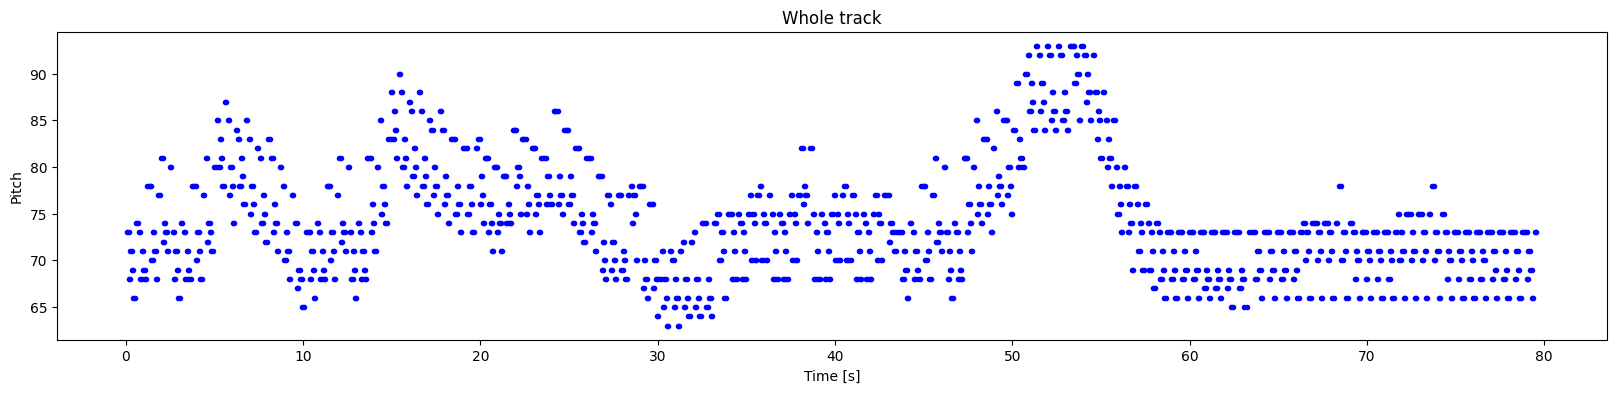

In [7]:
plot_piano_roll(raw_notes)

## Creating MIDI Files

By transforming note information, such as pitch, duration, and timing, into a MIDI file, we are enabled to hear the song.

In [8]:
def create_midi_from_notes(
    note_dataframe: pd.DataFrame,
    target_file: str,
    chosen_instrument: str,
    note_intensity: int = 100  # Intensity of the note
) -> pretty_midi.PrettyMIDI:

    midi_creation = pretty_midi.PrettyMIDI()
    midi_instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(chosen_instrument))

    last_start = 0
    for index, single_note in note_dataframe.iterrows():
        note_start = last_start + float(single_note['time_step'])
        note_end = note_start + float(single_note['duration'])
        midi_note = pretty_midi.Note(
            velocity=int(note_intensity),
            pitch=int(single_note['pitch']),  # Converting pitch to int
            start=note_start,
            end=note_end,
        )
        midi_instrument.notes.append(midi_note)
        last_start = note_start

    midi_creation.instruments.append(midi_instrument)
    midi_creation.write(target_file)
    return midi_creation


In [9]:
from google.colab import files

example_file = 'example.midi'
example_pm = create_midi_from_notes(note_dataframe=raw_notes, target_file=example_file, chosen_instrument='Overdriven Guitar')


files.download(example_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Formulating the Training Dataset
In this section, we undertake the task of formulating the training dataset, a pivotal step in the process of training our model. The initial phase involves the extraction of musical notes from MIDI files. For the sake of initial experimentation and to maintain computational efficiency, we commence with a relatively small subset of files. As progress is made, one can incrementally include a larger corpus of MIDI files. It should be noted that this extraction process may require a few minutes, contingent upon the number of files and the complexity of their content.

Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [10]:
# Define the number of MIDI files to process
files_to_process = 200
collected_notes = []

# Iteratively process each MIDI file and extract notes
for file_path in midi_files[:files_to_process]:
    extracted_notes = convert_midi_to_dataframe(file_path)
    collected_notes.append(extracted_notes)

# Consolidate all extracted notes into a single DataFrame
consolidated_notes = pd.concat(collected_notes)
total_notes_count = len(consolidated_notes)
print(f'Total number of extracted notes: {total_notes_count}')


Total number of extracted notes: 40305


## Generation of TensorFlow Dataset
Following the assembly of the training dataset, the subsequent step is to convert the parsed notes into a TensorFlow dataset.  The tf.data.Dataset structure will be employed to encapsulate our notes data, ensuring  compatibility with TensorFlow's training procedures.

In [11]:
# Define the order of features in our dataset
feature_order = ['pitch', 'duration', 'time_step']
structured_notes = np.stack([consolidated_notes[feature] for feature in feature_order], axis=1)

# Convert the structured array into a TensorFlow dataset
training_dataset = tf.data.Dataset.from_tensor_slices(structured_notes)
print(training_dataset.element_spec)


TensorSpec(shape=(3,), dtype=tf.float64, name=None)



**Enhancing Model Training with Sequential Data**

### RNN-Based Learning for Musical Sequences

The fundamental aspect of our strategy is to train a model, specifically a Recurrent Neural Network (RNN), on batches of sequential musical note data. Each training example consists of a series of notes, acting as input features, and the immediate subsequent note, serving as the target label. This approach is meticulously crafted to enable the RNN model to discern and predict the forthcoming note in a musical sequence.

#### Why RNNs for Music Sequences?

RNNs are uniquely suited for sequential data analysis due to their inherent design, which allows them to maintain a 'memory' of previous inputs through internal states. This memory is instrumental in understanding the context in a sequence, making RNNs ideal for applications like music generation where the relevance of a note often depends on preceding notes.

Mathematically, the hidden state \( h_t \) at time step \( t \) in an RNN is updated as follows:

\[ h_t = f(W_{hh}h_{t-1} + W_{xh}x_t + b_h) \]

Where:
- \( h_{t-1} \) is the previous hidden state.
- \( x_t \) is the input at time step \( t \).
- \( W_{hh} \) and \( W_{xh} \) are the weights.
- \( b_h \) is the bias.
- \( f \) is the activation function, often a non-linear function like tanh or ReLU.

### Windowing Technique for Structuring Data

To adapt our data for RNN training, we employ a windowing technique, whereby each window encapsulates a sequence of notes of a predetermined length (`sequence_length`). This technique segments our dataset into a sequence of input features and their corresponding next-note labels, which is critical for training our RNN.

This windowing effectively prepares the dataset for the RNN, allowing the model to learn the temporal dependencies and patterns inherent in music. The sequence length `sequence_length` is a crucial hyperparameter, as it determines the extent of temporal context the model will consider for each prediction.

By applying this windowing method, we transform our musical data into a format conducive to the unique strengths of RNNs, setting the stage for effective training and generation of music sequences.


In [12]:
def generate_note_sequences(dataset: tf.data.Dataset, sequence_length: int, total_notes: int = 128) -> tf.data.Dataset:
    """Generates a TensorFlow Dataset of note sequences and corresponding labels."""
    sequence_length += 1  # Include extra note for labeling

    # Create windows of notes
    note_windows = dataset.window(sequence_length, shift=1, stride=1, drop_remainder=True)

    # Flatten the nested dataset structure
    flatten_windows = lambda window: window.batch(sequence_length, drop_remainder=True)
    note_sequences = note_windows.flat_map(flatten_windows)

    # Function to normalize note pitch
    def normalize_pitch(note_sequence):
        normalized_sequence = note_sequence / [total_notes, 1.0, 1.0]
        return normalized_sequence

    # Function to separate inputs and labels
    def separate_labels(note_sequence):
        input_features = note_sequence[:-1]
        label = note_sequence[-1]
        label_dict = {feature_name: label[idx] for idx, feature_name in enumerate(['pitch', 'duration', 'time_step'])}

        return normalize_pitch(input_features), label_dict

    return note_sequences.map(separate_labels, num_parallel_calls=tf.data.AUTOTUNE)


# Optimal Sequence Length Determination and Vocabulary Size

Defining the Sequence Length
In the realm of Recurrent Neural Network (RNN) based music generation, the length of the input sequence (denoted as sequence_length) plays a major role in model performance. This length determines the number of notes the RNN will consider when making a prediction about the next note in a sequence. A judicious selection of sequence_length is paramount, as it directly influences the model's ability to capture temporal dependencies in the music data.

The vocab_size is set at 128, mirroring the total pitches available in the pretty_midi library, thereby encompassing the entire range of standard MIDI pitches.

In [13]:
# Setting sequence length and vocabulary size
sequence_length = 64
pitch_vocabulary_size = 128

# Generating the note sequences dataset
sequence_dataset = generate_note_sequences(training_dataset, sequence_length, pitch_vocabulary_size)
print(sequence_dataset.element_spec)


(TensorSpec(shape=(64, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None), 'time_step': TensorSpec(shape=(), dtype=tf.float64, name=None)})


### Estrutura do Dataset e Alvo da Predição
A estrutura do dataset, especialmente no contexto de uma RNN, oferece uma compreensão sobre a configuração dos dados de entrada e saída. No nosso caso, a estrutura do dataset (64, 3) indica que o modelo processará 128 conjuntos de 3 valores cada como entrada. Cada conjunto destes representa, respectivamente, a altura da nota (pitch), o intervalo de tempo desde a última nota (step), e a duração da nota (duration). Com isso, o objetivo é prever não apenas a próxima nota em sequência, mas também suas características temporais e de duração. Esta abordagem é fundamental para que a RNN aprenda o padrão de progressão das notas em sequências musicais, incorporando não apenas a melodia, mas também o ritmo e a dinâmica da composição.

### Otimização de Dados para Treinamento Eficiente de Modelo RNN

#### Configuração de Batching e Performance

A preparação eficiente do dataset para treinamento de um modelo RNN envolve a criação de batches e a configuração otimizada de desempenho. O `batch_size` é definido como 128, permitindo que o modelo processe 128 exemplos em cada etapa de treinamento.

O `buffer_size`, calculado como o total de notas menos o comprimento da sequência, é usado no embaralhamento do dataset. O embaralhamento é feito na ordem das sequências no dataset, mantendo a ordem das notas dentro de cada sequência. Isso evita o overfitting, garantindo que o modelo aprenda padrões gerais em vez da ordem específica das sequências.

O dataset é então configurado para melhorar a velocidade de treinamento, utilizando caching para armazenar os dados em memória após o embaralhamento e batching. O prefetching com `tf.data.experimental.AUTOTUNE` é aplicado para otimizar a pré-busca de dados, aprimorando a eficiência do treinamento.

In [14]:
# Definição do tamanho do batch e do buffer size
batch_size = 128
buffer_size = total_notes_count - sequence_length  # Número de itens no dataset

# Preparação do dataset de treinamento
train_dataset = (sequence_dataset
            .shuffle(buffer_size)  # Embaralha os dados utilizando o buffer_size
            .batch(batch_size, drop_remainder=True)  # Cria batches de tamanho definido, descartando os dados restantes
            .cache()  # Armazena o dataset em cache para acelerar o acesso durante o treinamento
            .prefetch(tf.data.experimental.AUTOTUNE))  # Pré-busca dos dados para otimizar o carregamento


In [15]:
train_dataset.element_spec

(TensorSpec(shape=(128, 64, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(128,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(128,), dtype=tf.float64, name=None),
  'time_step': TensorSpec(shape=(128,), dtype=tf.float64, name=None)})

## Criação e Treinamento do Modelo
 ### Estrutura e Função de Perda do Modelo

 A Huber Loss é uma função de perda robusta que é particularmente eficaz ao lidar com outliers nos dados. Esta função combina as características do erro quadrático médio (MSE) e do erro absoluto médio (MAE), sendo quadrática para erros menores e linear para erros maiores. Essa propriedade torna a Huber Loss uma escolha adequada para a previsão das características step e duration em nosso modelo de RNN, especialmente porque esperamos a presença de outliers. Ao minimizar o impacto desses pontos atípicos, a Huber Loss permite um aprendizado mais estável e confiável.

 Nesta implementação, a HuberLossPositivePressure é uma classe personalizada que estende a funcionalidade da Huber Loss, adicionando um termo que penaliza as previsões negativas. O parâmetro positive_pressure_weight controla a intensidade dessa penalidade. Esse ajuste é particularmente útil para as características step e duration, onde valores negativos não são desejáveis.

In [16]:
from tensorflow.keras.losses import Loss
import tensorflow as tf

class HuberLossPositivePressure(Loss):
    def __init__(self, delta=1.0, positive_pressure_weight=10.0, **kwargs):
        super().__init__(**kwargs)
        self.delta = delta
        self.positive_pressure_weight = positive_pressure_weight

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.delta
        squared_loss = tf.square(error) / 2
        linear_loss = self.delta * (tf.abs(error) - self.delta / 2)

        loss = tf.where(is_small_error, squared_loss, linear_loss)
        positive_pressure = self.positive_pressure_weight * tf.maximum(-y_pred, 0.0)

        return tf.reduce_mean(loss + positive_pressure)

# Uso da HuberLossPositivePressure personalizada
input_shape = (sequence_length, 3)
learning_rate = 0.01

inputs = tf.keras.Input(input_shape)

# Primeira camada LSTM com return_sequences=True
x = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)

# Segunda camada LSTM
x = tf.keras.layers.LSTM(32)(x)

# Camadas de saída
outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
  'time_step': tf.keras.layers.Dense(1, name='time_step')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'duration': HuberLossPositivePressure(),
    'time_step': HuberLossPositivePressure(),
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 64, 128)              67584     ['input_1[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 32)                   20608     ['lstm[0][0]']                
                                                                                                  
 duration (Dense)            (None, 1)                    33        ['lstm_1[0][0]']              
                                                                                              

Vamos avaliar o modelo antes do treinamento


In [17]:
losses = model.evaluate(train_dataset, return_dict=True)
losses

314/314 [==============================] - 26s 6ms/step - loss: 5.6069 - duration_loss: 0.6972 - pitch_loss: 4.8459 - time_step_loss: 0.0638


{'loss': 5.606943130493164,
 'duration_loss': 0.6971966624259949,
 'pitch_loss': 4.845920085906982,
 'time_step_loss': 0.06382777541875839}

Vamos usar pesos para balancear a funcao de perda e entao avaliar novamente


In [18]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.1,
        'step': 1,
        'duration':1,
    },
    optimizer=optimizer,
)

model.evaluate(train_dataset, return_dict=True)

314/314 [==============================] - 3s 6ms/step - loss: 1.2456 - duration_loss: 0.6972 - pitch_loss: 4.8459 - time_step_loss: 0.0638


{'loss': 1.2456164360046387,
 'duration_loss': 0.6971966624259949,
 'pitch_loss': 4.845920085906982,
 'time_step_loss': 0.06382777541875839}

## Treinar o modelo

In [19]:
training_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/checkpoint_epoch_{epoch}',
        save_weights_only=True,
        save_best_only=True,
        monitor='loss',
        mode='min'),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=0.001,
        patience=10,
        verbose=2,
        mode='min',
        restore_best_weights=False)
]


In [20]:
# para checar se estamos conectados a GPU.
# reduzi treinamento de 3h para 6 minutos com a GPU.

!nvidia-smi




Wed Dec 20 17:36:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              45W /  70W |    203MiB / 15360MiB |     31%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
import time

# Iniciar a medição do tempo
start_time = time.time()

# Definindo o número de épocas
total_epochs = 500

# Treinando o modelo
training_history = model.fit(
    train_dataset,
    epochs=total_epochs,
    callbacks=training_callbacks,  # Supondo que a lista de callbacks foi renomeada
)

# Calculando o tempo total de treinamento
elapsed_time = time.time() - start_time
print(f"Tempo total de treinamento: {elapsed_time:.2f} segundos")


Epoch 1/500
314/314 [==============================] - 8s 10ms/step - loss: 0.4666 - duration_loss: 0.0484 - pitch_loss: 3.7677 - time_step_loss: 0.0415
Epoch 2/500
314/314 [==============================] - 3s 9ms/step - loss: 0.4187 - duration_loss: 0.0390 - pitch_loss: 3.4568 - time_step_loss: 0.0340
Epoch 3/500
314/314 [==============================] - 3s 10ms/step - loss: 0.3862 - duration_loss: 0.0380 - pitch_loss: 3.1749 - time_step_loss: 0.0307
Epoch 4/500
314/314 [==============================] - 3s 9ms/step - loss: 0.3755 - duration_loss: 0.0368 - pitch_loss: 3.1079 - time_step_loss: 0.0279
Epoch 5/500
314/314 [==============================] - 3s 9ms/step - loss: 0.3691 - duration_loss: 0.0358 - pitch_loss: 3.0695 - time_step_loss: 0.0263
Epoch 6/500
314/314 [==============================] - 3s 10ms/step - loss: 0.3643 - duration_loss: 0.0347 - pitch_loss: 3.0411 - time_step_loss: 0.0255
Epoch 7/500
314/314 [==============================] - 3s 10ms/step - loss: 0.3584 - 

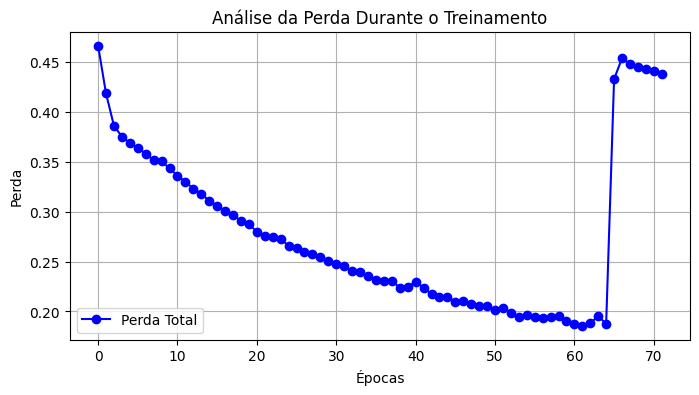

In [22]:
import matplotlib.pyplot as plt

# Preparando os dados para plotagem
epochs = training_history.epoch
total_loss = training_history.history['loss']

# Criando o gráfico
plt.figure(figsize=(8, 4))  # Definindo o tamanho da figura
plt.plot(epochs, total_loss, color='blue', marker='o', linestyle='-', label='Perda Total')  # Plotando a perda total
plt.title('Análise da Perda Durante o Treinamento')  # Título do gráfico
plt.xlabel('Épocas')  # Rótulo do eixo x
plt.ylabel('Perda')  # Rótulo do eixo y
plt.legend()  # Adicionando a legenda
plt.grid(True)  # Adicionando uma grade para melhor leitura
plt.show()  # Exibindo o gráfico


## Geração de Notas Musicais com Modelo Sequencial

Para gerar notas musicais utilizando o modelo treinado, inicialmente é necessário fornecer uma sequência inicial de notas. A função apresentada a seguir é responsável por gerar uma única nota baseada em uma sequência de notas existente.

Diferentemente de selecionar a nota mais provável em cada passo, a função utiliza uma abordagem baseada na distribuição softmax das notas produzidas pelo modelo, realizando uma amostragem. Esse método evita a criação de sequências repetitivas e monótonas.

O parâmetro temperature influencia a aleatoriedade na geração.

In [23]:
def gerar_nota(
    notas: np.ndarray,
    modelo: tf.keras.Model,
    temperatura: float = 3.0) -> tuple[int, float, float]:
  """Gera uma nota no formato (altura, passo, duração) usando um modelo sequencial treinado."""

  if temperatura <= 0:
      raise ValueError("A temperatura deve ser maior que zero.")

  # Adicionando dimensão para o batch
  entradas = tf.expand_dims(notas, 0)

  predicoes = modelo.predict(entradas)
  logitos_altura = predicoes['pitch']
  duracao = predicoes['duration']
  passo_tempo = predicoes['time_step']

  # Ajustando os logits pela temperatura
  logitos_altura /= temperatura
  altura = tf.random.categorical(logitos_altura, num_samples=1)
  altura = tf.squeeze(altura, axis=-1)
  duracao = tf.squeeze(duracao, axis=-1)
  passo_tempo = tf.squeeze(passo_tempo, axis=-1)

  # Assegurando que `passo_tempo` e `duracao` sejam valores não-negativos
  passo_tempo = tf.maximum(0, passo_tempo)
  duracao = tf.maximum(0, duracao)

  return int(altura.numpy()), float(passo_tempo.numpy()), float(duracao.numpy())


In [24]:
temperature = 2.0
num_predictions = 300
total_notes = 128

sample_notes = np.stack([raw_notes[key] for key in feature_order], axis=1)

input_notes = (
    sample_notes[:sequence_length] / np.array([total_notes, 1, 1]))

num_notes_in_sample = sample_notes.shape[0]


generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, time_step, duration = gerar_nota(input_notes, model, temperature)
  start = prev_start + time_step
  end = start + duration
  input_note = (pitch, duration, time_step)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*feature_order, 'start', 'end'))

1/1 [==============================] - 0s 30ms/step


In [25]:
out_file = 'output.mid'
out_pm = create_midi_from_notes(generated_notes, target_file=out_file, chosen_instrument='Acoustic Grand Piano')
#out_pm = create_midi_from_notes(generated_notes, target_file=out_file, chosen_instrument='Overdriven Guitar')

from google.colab import files
files.download(out_file)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['time_step'], 100 - drop_percentile)
  sns.histplot(notes, x="time_step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

  plot_distributions(raw_notes)
plot_distributions(generated_notes)

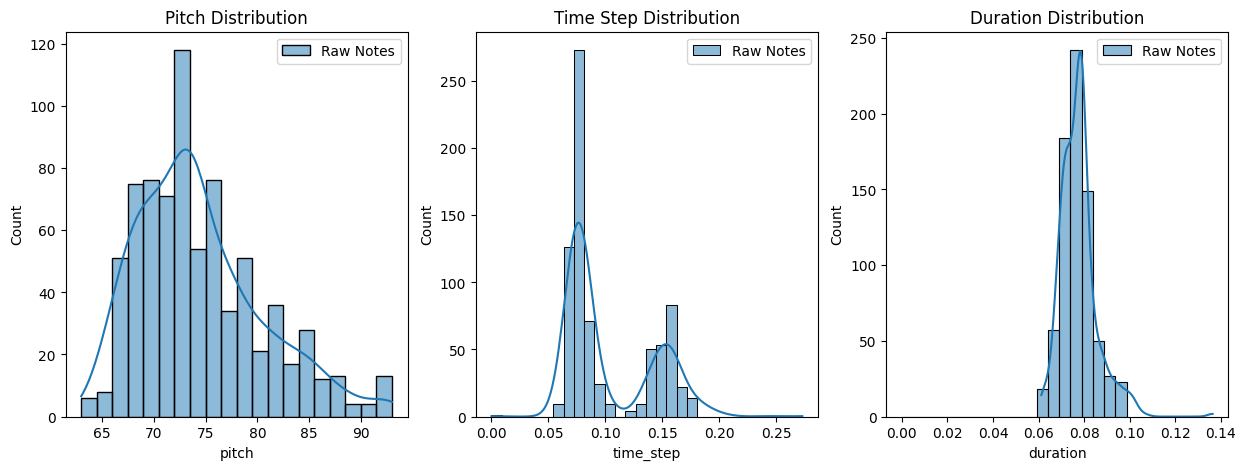

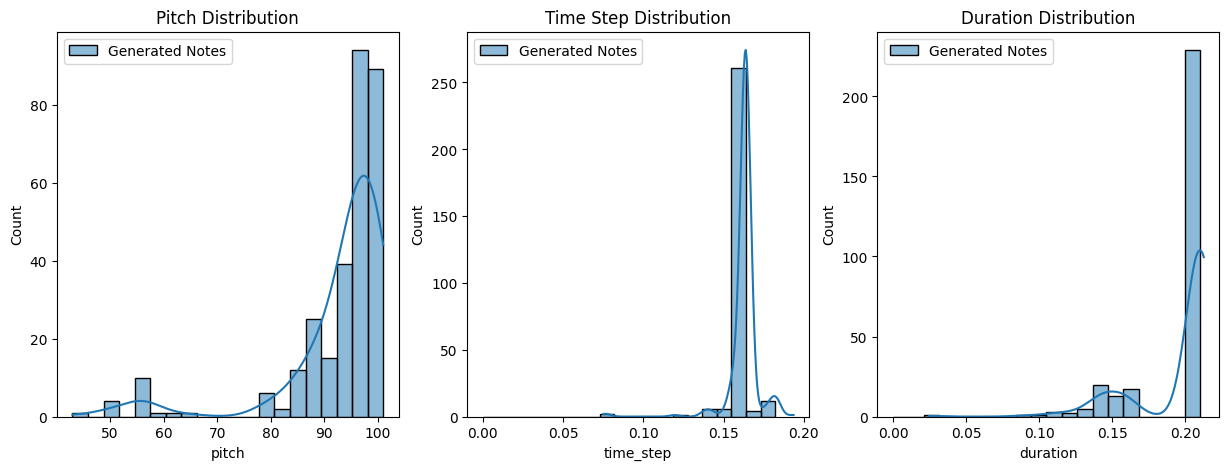

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_distributions(notes: pd.DataFrame, label: str, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])

    # Plot pitch
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20, label=label, kde=True)
    plt.legend()
    plt.title("Pitch Distribution")

    # Plot time_step
    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['time_step'], 100 - drop_percentile)
    sns.histplot(notes, x="time_step", bins=np.linspace(0, max_step, 21), label=label, kde=True)
    plt.legend()
    plt.title("Time Step Distribution")

    # Plot duration
    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21), label=label, kde=True)
    plt.legend()
    plt.title("Duration Distribution")

    plt.show()

# Exemplo de como chamar a função para a música de exemplo e a música gerada
plot_distributions(raw_notes, label='Raw Notes')
plot_distributions(generated_notes, label='Generated Notes')
